1. Для реализованной модели построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров.

Первая подзадача, по-видимому, уже реализована в исходном коде: ведь число деревьев и число итераций в данном контексте синонимы?! Попробую тогда строить двумерные графики для лучшей полноты выводов

In [2]:
from sklearn.tree import DecisionTreeRegressor

from sklearn import model_selection
import numpy as np

In [3]:
from sklearn.datasets import load_diabetes

In [4]:
X, y = load_diabetes(return_X_y=True)

Разделим выборку на обучающую и тестовую в соотношении 75/25.

In [5]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

Напишем функцию, реализующую предсказание в градиентном бустинге.

In [6]:
def gb_predict(X, trees_list, coef_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании прибавляются с шагом eta
    return np.array([sum([eta* coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) for x in X])

В качестве функционала ошибки будем использовать среднеквадратичную ошибку. Реализуем соответствующую функцию.

In [7]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

In [8]:
def bias(y, z):
    return (y - z)

Реализуем функцию обучения градиентного бустинга.

In [9]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, bias(y_train, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

Теперь обучим несколько моделей с разными параметрами и исследуем их поведение.

In [63]:
# Число деревьев в ансамбле
n_trees = 40

# для простоты примем коэффициенты равными 1
coefs = [1] * n_trees

# Максимальная глубина деревьев
max_depth = 12

# Шаг
eta = 0.2

In [64]:
# строим двумерную таблицу: по 0-оси число деревьев, по 1- оси макс.глубина 
tab_err_trn,tab_err_tst = [],[]
for depth in range(1,max_depth+1):
    trees, train_errors, test_errors = gb_fit(n_trees, depth, X_train, X_test, y_train, y_test, coefs, eta)
    tab_err_trn.append(train_errors)
    tab_err_tst.append(test_errors)
#print(tab_err_trn)
#print(tab_err_tst)

In [19]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

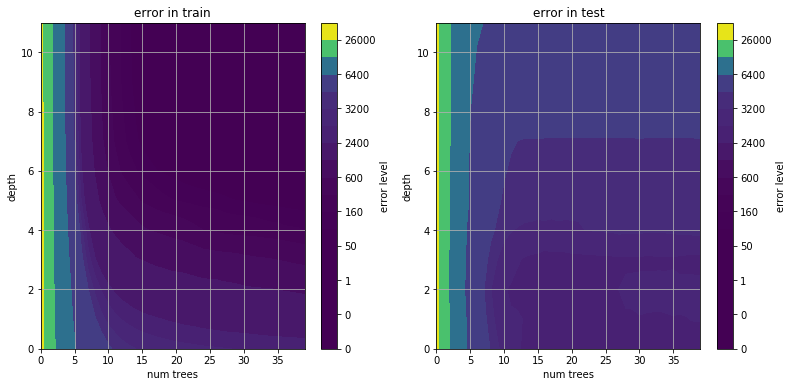

In [71]:
lvl = [0.0001,0.001,0.01,0.1,1,10,50,80,160,320,600,1200,2400,2800,3200,3600,6400,14000,26000,28000]

fig = plt.figure(figsize=(13, 6))
plt.subplot(121)
cc = plt.contourf(tab_err_trn,lvl)
cbar = plt.colorbar(cc)
cbar.ax.set_ylabel('error level')
plt.xlabel('num trees')
plt.ylabel('depth')
plt.title('error in train')
plt.grid(True)

plt.subplot(122)
#cc = plt.contourf(tab_err_tst,100)
cc = plt.contourf(tab_err_tst,lvl)

cbar = plt.colorbar(cc)
cbar.ax.set_ylabel('error level')
plt.xlabel('num trees')
plt.ylabel('depth')
plt.title('error in test')
plt.grid(True)

Выводы: на малом количестве деревьев (до 5-10) улучшение точности заканчивается сразу на первых уровнях глубины. 
Увеличивая количество деревьев, удается хорошо обучать лес на тренировочном наборе на глубинах более 7, но уже на бОльших
глубинах тестовый набор дает снижение точности по сравнению с тренировочным набором, т.е. возникает эффект переобучения. 
Устранить его позволяет лишь выбор еще большего числа деревьев. 

Т.е. - каждой глубине требуется достаточное количество деревьев